# CNN模型

目标：创建CNN模型来分类蔬菜和水果，使用TensorFlow实现。

* [Tutorial 1](https://www.tensorflow.org/tutorials/images/classification)
* [Tutorial 2](https://www.tensorflow.org/tutorials/keras/classification)

In [2]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

tf.get_logger().setLevel('INFO')

plt.style.use("ggplot")

# 数据预处理

使用`image_dataset_from_directory`辅助函数来创建数据集。

图像必须以标准化格式存储，例如：

dataset_root_dir/
  - class_a/
    - 00001.png
    - 00002.png
  - class_b/
    - 00001.png
    - 00002.png
  - class_c/
    - 00001.png
    - 00002.png

In [3]:
train_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/train",
    batch_size=32,
    image_size=(64, 64),
    validation_split=0,
    seed=123
)

val_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/validation/",
    batch_size=32,
    image_size=(64, 64),
)

test_set = tf.keras.utils.image_dataset_from_directory(
    directory="../data/test",
    batch_size=32,
    image_size=(64, 64)
)

Found 3114 files belonging to 36 classes.


2023-10-29 09:50:11.300344: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-29 09:50:11.300370: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-29 09:50:11.300378: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-29 09:50:11.300409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-29 09:50:11.300427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [4]:
class_names = train_set.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


# 定义模型架构

### 什么是模型架构？

模型架构是指如何设计神经网络来解决当前的问题，这包括指定网络层的数量和类型，以及层与层之间的连接。

### CNN模型架构

1. 输入层(Input layer)：图像数据，结构化网格数据
2. 卷积层(Convolutional Layers)：这是CNN模型的核心组件，卷积层将滤波器应用到输入图像上以提取特征。
    + 滤波器(Filter/Kernal)：滤波器是一个小的矩阵，它在图像上滑动以提取特征，例如边缘，纹理等。滤波器的大小通常是3x3或5x5。
    + 特征图(Feature map)：将滤波器应用到图像后得到特征图，特征图可以看作是滤波器检测到的特征的图像表示。
    + 例子：试想一个能识别眼睛的滤镜，它会在人脸图像上移动，自动识别并提取眼睛的部分。
3. 激活函数(Activation function)：Relu(整流线型单元)激活函数作用于卷积层的输出，它将负值替换为0，从而为模型引入非线性。现实世界中的大多数都是非线性的，因此需要引入非线性来模拟现实世界。
4. 池化层(Pooling layers)：减少特征图的空间维度，同时保留最多的信息。常见技术包括最大池化和平均池化。
    - 最大池化：特征图中每个2*2区域的最大值被保留，其它值被抛弃。
    - 平均池化：特征图中每个2*2区域的平均值被保留，其它值被抛弃。
5. 全部连接层(Fully Connected Layers)：这是典型的神经网络层，它运用前几层的输出，来对输入进行分类，可以理解为一个通用分类器。
    - 在进入全部连接层之前，需要将二维特征图扁平化为一维向量，然后输入全连接层。
6. 输出层(Output layer)：输出一个向量，表示每个类别的概率。

### CNN模型架构总结

* 卷积层：从输入图像中学习并提取特征
* 池化层：减少特征空间的维度
* 全部连接层：根据学习到的模式来分类结果

### 如何定义CNN模型架构？

最佳实践是什么？有哪些超参数？它们如何影响模型性能？

* 卷积层和池化层：需要多少个卷积层？滤波器数量，滤波器大小，激活函数都是模型的参数，滤波器越多，越能捕捉复杂的模式，但是也会增加计算成本。
* 池化层：池大小和跨度决定降维的幅度。
* 全连接层：需要定义神经元的数量，这会影响模型的复杂度，神经元数量过多会导致过拟合，神经元数量过少会导致欠拟合。
* 激活函数："Relu"通常用于隐藏层，"sigmoid"则用于二元分类输出层，"softmax"用于多元分类输出层。
* 损失函数：影响模型的训练方式。
* 优化算法：优化算法（如"Adam"）会影响模型权重在训练过程中的更新方式。
* 批量大小和Epochs：这是训练参数，批量大小控制着一次处理多少样本，而Epochs则决定着在训练过程中处理整个数据集的次数。

要确定特定问题的最佳参数，需要进行实验和超参数调整，通过观察验证集的损失和准确率来确定最佳参数。


需要多少个卷积层？

1. 从简单架构开始，必要时逐步提高复杂度。对于小型或中等复杂问题，一般从2-4个卷积层开始。
2. 一般来说，卷积层越多，模型越复杂，越能学习到复杂的特征，但是也会增加计算成本。
3. 可以根据问题的复杂程度来决定卷积层的数量。一般来说较早的网络层会学习边缘等简单特征，较深的层会学习纹理和形状等复杂特征，如果要识别非常复杂的物体，可能需要很多层。

简单问题（如猫与狗）：
* 2-3 个卷积层
* 1-2 层全连接层
* 过滤器/神经元数量相对较少

中等复杂问题（如花卉品种分类）：
* 4-5 个卷积层
* 2-3 个全连接层
* 过滤器/神经元数量适中

复杂问题（如细粒度物体识别）：
* 6个或更多卷积层
* 3个或更多全连接层
* 大量过滤器/神经元

如何定义超参数？

* [A guide to an efficient way to build neural network architectures(part1)](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b)
* [A guide to an efficient way to build neural network architectures(part2)](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7)

最佳实践：

1. 一开始使用较小的滤波器，以收集尽可能多的局部信息，然后逐渐增加滤波器宽度，开始采集更多的全局信息。
2. 一开始的通道数量应该较少，以便监测到低层次的特征，然后增加通道数量，将低层次特征组合起来形成复杂的模式。按照惯例，在卷积神经网络中逐层推进时，通道数量会增加或保持不变。
3. 对于中等或较小图像，卷积层的滤波器大小一般为$3*3$, $5*5$, $7*7$，对于较大的图像，可以使用更大的滤波器。
4. 一般来说，池化层的大小为$2*2$，跨度为2，这样可以将特征图的大小减少一半。
5. 不断增加层数，直到过度拟合，然后使用正则化和数据增强来降低过拟合的程度。
6. 在构建模型架构时，请始终将 LeNet, AlexNet, VGG-16, VGG-19 等经典网络作为灵感来源。所谓灵感，是指遵循架构中使用的趋势，例如 Conv-Pool-Conv-Pool 或 Conv-Conv-Pool-Conv-Conv-Pool 层的趋势，或通道数 32-64-128 或 32-32-64-64 的趋势，或过滤器大小、最大池化参数等的趋势。

如何将经典网络作为灵感来源？

Always use classic networks like LeNet, AlexNet, VGG-16, VGG-19 etc. as an inspiration while building the architectures for your models. By inspiration i mean follow the trend used in the architectures for example trend in the layers Conv-Pool-Conv-Pool or Conv-Conv-Pool-Conv-Conv-Pool or trend in the Number of channels 32–64–128 or 32–32-64–64 or trend in filter sizes, Max-pooling parameters etc.

选择一个经典网络，VGG-19，根据VGG-19的架构来设计一个简化模型，然后对参数进行调整。

### Chatgpt

Certainly! I can help you design a simplified CNN architecture inspired by VGG-19 for your small image classification problem. Since VGG-19 is quite deep and may be overkill for a small problem, we'll create a lighter version with fewer layers. Below is a table representing the architecture of the CNN model:

| Layer   | Type          | Number of Filters | Kernel Size | Stride | Padding | Activation Function | Output Size |
|---------|---------------|--------------------|-------------|--------|---------|---------------------|-------------|
| Input   | Input         | -                  | -           | -      | -       | -                   | (Image Size) |
| Conv1_1 | Convolutional | 64                 | 3x3         | 1      | Same    | ReLU                | (Image Size) |
| Conv1_2 | Convolutional | 64                 | 3x3         | 1      | Same    | ReLU                | (Image Size) |
| MaxPool1| Max-Pooling   | -                  | 2x2         | 2      | Valid   | -                   | (Image Size/2) |
| Conv2_1 | Convolutional | 128                | 3x3         | 1      | Same    | ReLU                | (Image Size/2) |
| Conv2_2 | Convolutional | 128                | 3x3         | 1      | Same    | ReLU                | (Image Size/2) |
| MaxPool2| Max-Pooling   | -                  | 2x2         | 2      | Valid   | -                   | (Image Size/4) |
| Conv3_1 | Convolutional | 256                | 3x3         | 1      | Same    | ReLU                | (Image Size/4) |
| Conv3_2 | Convolutional | 256                | 3x3         | 1      | Same    | ReLU                | (Image Size/4) |
| Conv3_3 | Convolutional | 256                | 3x3         | 1      | Same    | ReLU                | (Image Size/4) |
| MaxPool3| Max-Pooling   | -                  | 2x2         | 2      | Valid   | -                   | (Image Size/8) |
| Flatten | Flatten       | -                  | -           | -      | -       | -                   | (Flattened)  |
| FC1     | Fully Connected| 512                | -           | -      | -       | ReLU                | 512         |
| FC2     | Fully Connected| 512                | -           | -      | -       | ReLU                | 512         |
| Output  | Fully Connected| Number of Classes | -           | -      | -       | Softmax             | Number of Classes |

Explanation of each layer:

1. **Input Layer**: This is where your image data is fed into the network. The size of the input depends on your image dimensions.

2. **Convolutional Layers**: These layers apply convolution operations to detect features in the input data. We have three sets of two convolutional layers each, with 3x3 filters and ReLU activation functions. You can adjust the number of filters based on your problem complexity.

3. **Max-Pooling Layers**: Max-pooling reduces the spatial dimensions of the feature maps and helps in reducing computational complexity. It uses 2x2 pooling with a stride of 2.

4. **Flatten Layer**: This layer flattens the 3D output from the previous layers into a 1D vector to prepare for the fully connected layers.

5. **Fully Connected Layers (FC1 and FC2)**: These are traditional neural network layers that take the flattened features from the convolutional layers and apply ReLU activation. You can adjust the number of neurons in these layers based on your problem complexity.

6. **Output Layer**: The final fully connected layer with a softmax activation function outputs class probabilities. The number of neurons here should match the number of classes in your classification problem.

This architecture follows the basic principles of VGG-19 but is simplified for a small problem. You can experiment with the number of filters, the size of convolutional kernels, and the number of neurons in the fully connected layers to fine-tune the model for your specific problem.

In [5]:
# import tensorflow as tf

# # Define the model
# model = tf.keras.Sequential([
#     # Input Layer
#     tf.keras.layers.Input(shape=(224, 224, 3)),  # Adjust the input shape to match your image dimensions

#     # Convolutional Layers
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),

#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),

#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2),

#     # Flatten Layer
#     tf.keras.layers.Flatten(),

#     # Fully Connected Layers
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),

#     # Output Layer
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # Replace 'num_classes' with the number of classes in your problem
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model.summary()

### Perplexity

To design a CNN model for a small image classification problem inspired by the VGG-19 architecture, you can follow the arrangement of VGG-19 for convolutional, pooling, and fully connected layers but adjust the number of network layers. Since you are classifying 10 classes, the final fully connected layer should have 10 channels. Here's a suggested architecture:

| Layer Type       | Filters | Kernel Size | Stride | Padding | Activation | Output Size |
|------------------|---------|-------------|--------|---------|------------|-------------|
| Input            | -       | -           | -      | -       | -          | 224x224x3   |
| Convolutional    | 32      | 3x3         | 1      | same    | ReLU       | 224x224x32  |
| Convolutional    | 32      | 3x3         | 1      | same    | ReLU       | 224x224x32  |
| Max Pooling      | -       | 2x2         | 2      | -       | -          | 112x112x32  |
| Convolutional    | 64      | 3x3         | 1      | same    | ReLU       | 112x112x64  |
| Convolutional    | 64      | 3x3         | 1      | same    | ReLU       | 112x112x64  |
| Max Pooling      | -       | 2x2         | 2      | -       | -          | 56x56x64    |
| Convolutional    | 128     | 3x3         | 1      | same    | ReLU       | 56x56x128   |
| Convolutional    | 128     | 3x3         | 1      | same    | ReLU       | 56x56x128   |
| Max Pooling      | -       | 2x2         | 2      | -       | -          | 28x28x128   |
| Fully Connected  | -       | -           | -      | -       | ReLU       | 4096        |
| Fully Connected  | -       | -           | -      | -       | ReLU       | 4096        |
| Fully Connected  | -       | -           | -      | -       | -          | 10          |
| Softmax          | -       | -           | -      | -       | -          | 10          |

This architecture is a simplified version of VGG-19, with fewer convolutional layers. It starts with an input size of 224x224, followed by two sets of convolutional and max-pooling layers. The number of filters in the convolutional layers increases as the network deepens. After the convolutional and pooling layers, there are three fully connected layers. The first two have 4096 channels each, and the third has 10 channels for the 10 classes. The final layer is a softmax layer, which outputs the probability distribution for each of the 10 classes.

In this architecture:

1. Convolutional layers are responsible for feature extraction, detecting features like edges, shapes, and patterns.
2. ReLU activation functions introduce non-linearity and help the network learn complex patterns.
3. Max pooling layers reduce the spatial dimensions while retaining the most important information.
4. Fully connected layers perform the classification task based on the features extracted by the convolutional layers.
5. The softmax layer outputs the probability distribution for each class.

This simplified architecture should be more suitable for a small image classification problem while still being inspired by the VGG-19 architecture.

In [6]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Initialize the model
# model = Sequential()

# # Add the first two convolutional layers
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

# # Add the first max pooling layer
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # Add the next two convolutional layers
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

# # Add the second max pooling layer
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # Add the next two convolutional layers
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# # Add the third max pooling layer
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # Flatten the tensor output from the previous layer
# model.add(Flatten())

# # Add the first two fully connected layers
# model.add(Dense(4096, activation='relu'))
# model.add(Dense(4096, activation='relu'))

# # Add the final fully connected layer with 10 outputs
# model.add(Dense(10, activation='softmax'))

In [7]:
image_height = 64
image_width = 64
num_classes = len(class_names)

model = tf.keras.models.Sequential(
    [
        # Data augmentation
        # tf.keras.layers.RandomFlip("horizontal", input_shape=(image_height, image_width, 3)),
        # tf.keras.layers.RandomRotation(0.1),
        # tf.keras.layers.RandomZoom(0.1),
        
        # Stadardization
        tf.keras.layers.Rescaling(
            1.0 / 255, input_shape=(image_height, image_width, 3)
        ),

        # Convolutional layers, pooling layers
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        
        # Apply dropout to reduce overfitting
        # tf.keras.layers.Dropout(0.2),

        # Flatten the output for fully connected layers
        tf.keras.layers.Flatten(),

        # Fully connected layers
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

编译模型

指定优化器，损失函数和评估指标。

一般采用什么设置？最佳实践是什么？

In [8]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

查看模型

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

训练模型

* 如何确定epoch的数量？
* 如何加速运算？
* 如何使用GPU？

In [10]:
epochs = 10
history = model.fit(
    train_set, validation_data=val_set, epochs=epochs
)

Epoch 1/10


2023-10-29 09:52:18.813584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-10-29 09:52:19.366786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:52:19.941123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:52:20.185211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 15s - loss: 3.6464 - accuracy: 0.0469     

2023-10-29 09:52:25.389191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 24s - loss: 3.6512 - accuracy: 0.0365

2023-10-29 09:52:26.164967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 26s - loss: 3.6391 - accuracy: 0.0391

2023-10-29 09:52:26.863229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 27s - loss: 3.6373 - accuracy: 0.0382

2023-10-29 09:52:27.152643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 23s - loss: 3.6225 - accuracy: 0.0312

2023-10-29 09:52:27.833633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 22s - loss: 3.6118 - accuracy: 0.0295

2023-10-29 09:52:29.496807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 19s - loss: 3.6029 - accuracy: 0.0312

2023-10-29 09:52:31.342077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 19s - loss: 3.5969 - accuracy: 0.0335

2023-10-29 09:52:32.453136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 18s - loss: 3.5908 - accuracy: 0.0385

2023-10-29 09:52:32.720613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 18s - loss: 3.5856 - accuracy: 0.0426

2023-10-29 09:52:33.902874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 16s - loss: 3.5725 - accuracy: 0.0481

2023-10-29 09:52:35.752831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 3.5591 - accuracy: 0.0511

2023-10-29 09:52:36.722060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 14s - loss: 3.5483 - accuracy: 0.0523

2023-10-29 09:52:37.457427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 14s - loss: 3.5465 - accuracy: 0.0519

2023-10-29 09:52:38.302672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 3.5178 - accuracy: 0.0516

2023-10-29 09:52:41.352129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 3.5015 - accuracy: 0.0566

2023-10-29 09:52:42.082761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 3.4970 - accuracy: 0.0573

2023-10-29 09:52:42.525748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 3.4900 - accuracy: 0.0579

2023-10-29 09:52:42.965447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 3.4784 - accuracy: 0.0590

2023-10-29 09:52:44.466151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 3.4451 - accuracy: 0.0637

2023-10-29 09:52:46.658136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 3.3882 - accuracy: 0.0716

2023-10-29 09:52:52.684509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:52:52.691396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 39s 338ms/step - loss: 3.3882 - accuracy: 0.0716 - val_loss: 2.9299 - val_accuracy: 0.1595
Epoch 2/10


2023-10-29 09:52:58.147296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:52:58.713911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:52:58.956455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 3.0580 - accuracy: 0.1484

2023-10-29 09:53:00.807746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 30s - loss: 3.0867 - accuracy: 0.1354

2023-10-29 09:53:01.589137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 30s - loss: 3.0540 - accuracy: 0.1289

2023-10-29 09:53:02.285462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 31s - loss: 2.9940 - accuracy: 0.1493

2023-10-29 09:53:02.576357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 3.0101 - accuracy: 0.1510

2023-10-29 09:53:03.246796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 23s - loss: 3.0181 - accuracy: 0.1510

2023-10-29 09:53:04.906170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 2.9518 - accuracy: 0.1600

2023-10-29 09:53:06.743368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 2.9457 - accuracy: 0.1641

2023-10-29 09:53:07.863403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.9225 - accuracy: 0.1625

2023-10-29 09:53:08.135325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 2.9057 - accuracy: 0.1686

2023-10-29 09:53:09.319467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 2.9053 - accuracy: 0.1723

2023-10-29 09:53:11.175265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.9161 - accuracy: 0.1683

2023-10-29 09:53:12.134027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.9133 - accuracy: 0.1671

2023-10-29 09:53:12.863968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 2.9153 - accuracy: 0.1682

2023-10-29 09:53:13.707294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 2.8922 - accuracy: 0.1734

2023-10-29 09:53:16.753685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 2.8663 - accuracy: 0.1802

2023-10-29 09:53:17.486731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 2.8550 - accuracy: 0.1832

2023-10-29 09:53:17.928394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 2.8548 - accuracy: 0.1838

2023-10-29 09:53:18.369286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 2.8442 - accuracy: 0.1862

2023-10-29 09:53:19.874621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.8225 - accuracy: 0.1934

2023-10-29 09:53:22.065489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.8002 - accuracy: 0.1997

2023-10-29 09:53:25.056108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:53:25.062046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 294ms/step - loss: 2.8002 - accuracy: 0.1997 - val_loss: 2.2897 - val_accuracy: 0.3390
Epoch 3/10


2023-10-29 09:53:28.933489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:53:29.506981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:53:29.751031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 2.4350 - accuracy: 0.3594

2023-10-29 09:53:31.669171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 30s - loss: 2.4013 - accuracy: 0.3542

2023-10-29 09:53:32.448350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 30s - loss: 2.4487 - accuracy: 0.3203

2023-10-29 09:53:33.142008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 31s - loss: 2.4716 - accuracy: 0.3160

2023-10-29 09:53:33.434444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 2.5262 - accuracy: 0.2839

2023-10-29 09:53:34.113952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 24s - loss: 2.5470 - accuracy: 0.2795

2023-10-29 09:53:35.777511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 2.5558 - accuracy: 0.2700

2023-10-29 09:53:37.626329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 2.5434 - accuracy: 0.2723

2023-10-29 09:53:38.754092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.5371 - accuracy: 0.2750

2023-10-29 09:53:39.023769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 2.5218 - accuracy: 0.2812

2023-10-29 09:53:40.212006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 2.5165 - accuracy: 0.2780

2023-10-29 09:53:42.074968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.5260 - accuracy: 0.2763

2023-10-29 09:53:43.034606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.5225 - accuracy: 0.2765

2023-10-29 09:53:43.776382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 2.5172 - accuracy: 0.2793

2023-10-29 09:53:44.622942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 2.5136 - accuracy: 0.2755

2023-10-29 09:53:47.706974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 2.5043 - accuracy: 0.2803

2023-10-29 09:53:48.454614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 2.4975 - accuracy: 0.2822

2023-10-29 09:53:48.912998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 2.4906 - accuracy: 0.2849

2023-10-29 09:53:49.364671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 2.4919 - accuracy: 0.2817

2023-10-29 09:53:50.887796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.4788 - accuracy: 0.2840

2023-10-29 09:53:53.123008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.4614 - accuracy: 0.2858

2023-10-29 09:53:56.137241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:53:56.144184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 296ms/step - loss: 2.4614 - accuracy: 0.2858 - val_loss: 1.7531 - val_accuracy: 0.4929
Epoch 4/10


2023-10-29 09:54:00.012678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:54:00.587756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:54:00.830934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 2.3320 - accuracy: 0.3359

2023-10-29 09:54:02.678785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 29s - loss: 2.4499 - accuracy: 0.2760

2023-10-29 09:54:03.454491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 2.4134 - accuracy: 0.2695

2023-10-29 09:54:04.144487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 30s - loss: 2.3735 - accuracy: 0.2882

2023-10-29 09:54:04.437162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 2.3327 - accuracy: 0.3073

2023-10-29 09:54:05.114418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 24s - loss: 2.2967 - accuracy: 0.3194

2023-10-29 09:54:06.804456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 2.2749 - accuracy: 0.3237

2023-10-29 09:54:08.652656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 2.2974 - accuracy: 0.3214

2023-10-29 09:54:09.766738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.3241 - accuracy: 0.3187

2023-10-29 09:54:10.041419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 2.3182 - accuracy: 0.3191

2023-10-29 09:54:11.249920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 2.3311 - accuracy: 0.3237

2023-10-29 09:54:13.106326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.3441 - accuracy: 0.3260

2023-10-29 09:54:14.078199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.3453 - accuracy: 0.3240

2023-10-29 09:54:14.815951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 2.3455 - accuracy: 0.3231

2023-10-29 09:54:15.657591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 2.3466 - accuracy: 0.3115

2023-10-29 09:54:18.713372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 2.3383 - accuracy: 0.3149

2023-10-29 09:54:19.444831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 2.3366 - accuracy: 0.3149

2023-10-29 09:54:19.887985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 2.3266 - accuracy: 0.3153

2023-10-29 09:54:20.325412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 2.3110 - accuracy: 0.3182

2023-10-29 09:54:21.825753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.2994 - accuracy: 0.3216

2023-10-29 09:54:24.121017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.2736 - accuracy: 0.3333

2023-10-29 09:54:27.165282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:54:27.172250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 296ms/step - loss: 2.2736 - accuracy: 0.3333 - val_loss: 1.6746 - val_accuracy: 0.4786
Epoch 5/10


2023-10-29 09:54:31.068174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:54:31.651932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:54:31.897240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 2.2767 - accuracy: 0.4375

2023-10-29 09:54:33.775388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 30s - loss: 2.2597 - accuracy: 0.4167

2023-10-29 09:54:34.559510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 30s - loss: 2.1853 - accuracy: 0.4336

2023-10-29 09:54:35.249018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 31s - loss: 2.1266 - accuracy: 0.4375

2023-10-29 09:54:35.542251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 2.0901 - accuracy: 0.4375

2023-10-29 09:54:36.220561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 23s - loss: 2.0966 - accuracy: 0.4219

2023-10-29 09:54:37.886724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 2.1296 - accuracy: 0.4000

2023-10-29 09:54:39.735241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 2.1131 - accuracy: 0.3984

2023-10-29 09:54:40.847697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 2.1025 - accuracy: 0.4000

2023-10-29 09:54:41.121925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 2.1653 - accuracy: 0.3930

2023-10-29 09:54:42.304169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 2.2179 - accuracy: 0.3878

2023-10-29 09:54:44.164393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.2414 - accuracy: 0.3793

2023-10-29 09:54:45.122617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.2553 - accuracy: 0.3757

2023-10-29 09:54:45.862789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 2.2535 - accuracy: 0.3730

2023-10-29 09:54:46.703708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 2.2728 - accuracy: 0.3557

2023-10-29 09:54:49.755321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 2.2702 - accuracy: 0.3550

2023-10-29 09:54:50.497380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 2.2688 - accuracy: 0.3532

2023-10-29 09:54:50.953478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 2.2606 - accuracy: 0.3557

2023-10-29 09:54:51.392586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 2.2434 - accuracy: 0.3587

2023-10-29 09:54:52.912287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.2384 - accuracy: 0.3608

2023-10-29 09:54:55.113513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


96/98 [============================>.] - ETA: 0s - loss: 2.2520 - accuracy: 0.3574

2023-10-29 09:54:58.536602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:54:58.539263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 300ms/step - loss: 2.2531 - accuracy: 0.3574 - val_loss: 1.7352 - val_accuracy: 0.4786
Epoch 6/10


2023-10-29 09:55:02.538224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:55:03.109793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:55:03.356935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 24s - loss: 2.0571 - accuracy: 0.4297

2023-10-29 09:55:05.235689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 29s - loss: 2.0184 - accuracy: 0.4271

2023-10-29 09:55:06.011696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 1.9564 - accuracy: 0.4414

2023-10-29 09:55:06.704081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 30s - loss: 2.0030 - accuracy: 0.4306

2023-10-29 09:55:06.997824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 2.0471 - accuracy: 0.4115

2023-10-29 09:55:07.669212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 23s - loss: 2.0262 - accuracy: 0.4167

2023-10-29 09:55:09.334674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 2.0630 - accuracy: 0.4137

2023-10-29 09:55:11.165436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 2.0476 - accuracy: 0.4096

2023-10-29 09:55:12.307314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/98 [=======>......................] - ETA: 19s - loss: 2.0373 - accuracy: 0.4170

2023-10-29 09:55:12.580133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 2.0412 - accuracy: 0.4195

2023-10-29 09:55:13.767500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 2.0411 - accuracy: 0.4239

2023-10-29 09:55:15.638142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 2.0743 - accuracy: 0.4197

2023-10-29 09:55:16.600869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.0631 - accuracy: 0.4219

2023-10-29 09:55:17.342783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 2.0664 - accuracy: 0.4209

2023-10-29 09:55:18.184426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 2.0883 - accuracy: 0.4104

2023-10-29 09:55:21.255643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 2.0776 - accuracy: 0.4136

2023-10-29 09:55:21.983643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 2.0732 - accuracy: 0.4129

2023-10-29 09:55:22.429426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 2.0666 - accuracy: 0.4136

2023-10-29 09:55:22.870811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 2.0650 - accuracy: 0.4129

2023-10-29 09:55:24.391225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 2.0618 - accuracy: 0.4110

2023-10-29 09:55:26.605409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 2.0480 - accuracy: 0.4149

2023-10-29 09:55:29.652062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:55:29.654896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 295ms/step - loss: 2.0480 - accuracy: 0.4149 - val_loss: 1.3331 - val_accuracy: 0.5812
Epoch 7/10


2023-10-29 09:55:33.532947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:55:34.105940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:55:34.351159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 1.8878 - accuracy: 0.4297

2023-10-29 09:55:36.187552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 29s - loss: 1.9913 - accuracy: 0.4167

2023-10-29 09:55:36.962228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 1.9559 - accuracy: 0.4453

2023-10-29 09:55:37.659052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 30s - loss: 1.9581 - accuracy: 0.4271

2023-10-29 09:55:37.954226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 1.9446 - accuracy: 0.4323

2023-10-29 09:55:38.626113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 24s - loss: 1.9130 - accuracy: 0.4497

2023-10-29 09:55:40.304444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 1.9485 - accuracy: 0.4325

2023-10-29 09:55:42.142064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 1.9527 - accuracy: 0.4364

2023-10-29 09:55:43.274080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.9533 - accuracy: 0.4385

2023-10-29 09:55:43.546804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 1.9387 - accuracy: 0.4403

2023-10-29 09:55:44.736757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 1.9493 - accuracy: 0.4423

2023-10-29 09:55:46.604964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.9865 - accuracy: 0.4396

2023-10-29 09:55:47.556803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 1.9895 - accuracy: 0.4389

2023-10-29 09:55:48.293018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 1.9980 - accuracy: 0.4388

2023-10-29 09:55:49.132899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 2.0060 - accuracy: 0.4344

2023-10-29 09:55:52.208298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 1.9978 - accuracy: 0.4351

2023-10-29 09:55:52.935697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 1.9853 - accuracy: 0.4380

2023-10-29 09:55:53.380197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 1.9926 - accuracy: 0.4393

2023-10-29 09:55:53.830791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 1.9913 - accuracy: 0.4410

2023-10-29 09:55:55.344955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 1.9733 - accuracy: 0.4486

2023-10-29 09:55:57.537700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


97/98 [============================>.] - ETA: 0s - loss: 1.9816 - accuracy: 0.4478

2023-10-29 09:56:00.567793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:56:00.575786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 295ms/step - loss: 1.9839 - accuracy: 0.4473 - val_loss: 1.4285 - val_accuracy: 0.5755
Epoch 8/10


2023-10-29 09:56:04.443059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:56:05.013065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:56:05.256592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 24s - loss: 1.8108 - accuracy: 0.5000

2023-10-29 09:56:07.092401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 29s - loss: 1.9547 - accuracy: 0.5000

2023-10-29 09:56:07.865580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 2.0385 - accuracy: 0.4844

2023-10-29 09:56:08.555944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 30s - loss: 2.0217 - accuracy: 0.4861

2023-10-29 09:56:08.850515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 2.0441 - accuracy: 0.4688

2023-10-29 09:56:09.530088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 23s - loss: 1.9963 - accuracy: 0.4618

2023-10-29 09:56:11.190327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 1.9496 - accuracy: 0.4663

2023-10-29 09:56:13.019452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 1.9639 - accuracy: 0.4609

2023-10-29 09:56:14.131240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.9448 - accuracy: 0.4719

2023-10-29 09:56:14.404730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 18s - loss: 1.9891 - accuracy: 0.4602

2023-10-29 09:56:15.581302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 1.9699 - accuracy: 0.4591

2023-10-29 09:56:17.453473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.9960 - accuracy: 0.4588

2023-10-29 09:56:18.401555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 2.0198 - accuracy: 0.4579

2023-10-29 09:56:19.135872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 2.0163 - accuracy: 0.4614

2023-10-29 09:56:19.973004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 1.9657 - accuracy: 0.4693

2023-10-29 09:56:23.000975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 1.9765 - accuracy: 0.4692

2023-10-29 09:56:23.734880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 1.9853 - accuracy: 0.4683

2023-10-29 09:56:24.180596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 1.9792 - accuracy: 0.4701

2023-10-29 09:56:24.620708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 1.9794 - accuracy: 0.4714

2023-10-29 09:56:26.132013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 1.9736 - accuracy: 0.4688

2023-10-29 09:56:28.333384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.9394 - accuracy: 0.4746

2023-10-29 09:56:31.353106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:56:31.361299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 293ms/step - loss: 1.9394 - accuracy: 0.4746 - val_loss: 1.4230 - val_accuracy: 0.5840
Epoch 9/10


2023-10-29 09:56:35.227081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:56:35.796891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:56:36.040586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 2.4083 - accuracy: 0.4219

2023-10-29 09:56:37.890983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 30s - loss: 2.1532 - accuracy: 0.4740

2023-10-29 09:56:38.667312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 30s - loss: 2.1033 - accuracy: 0.4805

2023-10-29 09:56:39.373518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/98 [=>............................] - ETA: 31s - loss: 2.1210 - accuracy: 0.4618

2023-10-29 09:56:39.664380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 2.1931 - accuracy: 0.4583

2023-10-29 09:56:40.336184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 24s - loss: 2.0535 - accuracy: 0.4774

2023-10-29 09:56:42.005468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 1.9812 - accuracy: 0.4850

2023-10-29 09:56:43.847389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 1.9965 - accuracy: 0.4810

2023-10-29 09:56:44.968729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.9939 - accuracy: 0.4875

2023-10-29 09:56:45.241526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 1.9746 - accuracy: 0.4896

2023-10-29 09:56:46.431946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 1.9803 - accuracy: 0.4928

2023-10-29 09:56:48.301525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.9821 - accuracy: 0.4950

2023-10-29 09:56:49.256850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 1.9875 - accuracy: 0.4932

2023-10-29 09:56:49.990474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 1.9943 - accuracy: 0.4914

2023-10-29 09:56:50.833469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 1.9814 - accuracy: 0.4880

2023-10-29 09:56:53.904751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 1.9599 - accuracy: 0.4902

2023-10-29 09:56:54.636817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 1.9454 - accuracy: 0.4929

2023-10-29 09:56:55.096694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 1.9385 - accuracy: 0.4936

2023-10-29 09:56:55.546654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 1.9366 - accuracy: 0.4925

2023-10-29 09:56:57.058436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 1.9441 - accuracy: 0.4933

2023-10-29 09:56:59.263144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.9418 - accuracy: 0.4936

2023-10-29 09:57:02.279162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:57:02.281686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 295ms/step - loss: 1.9418 - accuracy: 0.4936 - val_loss: 1.0396 - val_accuracy: 0.6866
Epoch 10/10


2023-10-29 09:57:06.165887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:57:06.736037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:57:06.978512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/98 [>.............................] - ETA: 25s - loss: 1.4452 - accuracy: 0.5547

2023-10-29 09:57:08.826485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/98 [>.............................] - ETA: 30s - loss: 1.7417 - accuracy: 0.5156

2023-10-29 09:57:09.599087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/98 [=>............................] - ETA: 29s - loss: 1.7231 - accuracy: 0.5039

2023-10-29 09:57:10.292329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:57:10.589052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/98 [==>...........................] - ETA: 25s - loss: 1.9043 - accuracy: 0.4609

2023-10-29 09:57:11.261680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/98 [====>.........................] - ETA: 23s - loss: 1.8917 - accuracy: 0.4792

2023-10-29 09:57:12.929914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/98 [======>.......................] - ETA: 20s - loss: 1.8675 - accuracy: 0.4850

2023-10-29 09:57:14.771533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/98 [=======>......................] - ETA: 20s - loss: 1.8844 - accuracy: 0.4866

2023-10-29 09:57:15.900594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/98 [========>.....................] - ETA: 19s - loss: 1.8661 - accuracy: 0.4896

2023-10-29 09:57:16.176453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


33/98 [=========>....................] - ETA: 19s - loss: 1.8464 - accuracy: 0.4896

2023-10-29 09:57:17.365381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


39/98 [==========>...................] - ETA: 17s - loss: 1.8706 - accuracy: 0.4904

2023-10-29 09:57:19.225659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


44/98 [============>.................] - ETA: 15s - loss: 1.9436 - accuracy: 0.4865

2023-10-29 09:57:20.188676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


46/98 [=============>................] - ETA: 15s - loss: 1.9369 - accuracy: 0.4885

2023-10-29 09:57:20.928545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


47/98 [=============>................] - ETA: 15s - loss: 1.9498 - accuracy: 0.4887

2023-10-29 09:57:21.778228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


60/98 [=================>............] - ETA: 10s - loss: 1.9621 - accuracy: 0.4891

2023-10-29 09:57:24.853519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


64/98 [==================>...........] - ETA: 9s - loss: 1.9380 - accuracy: 0.4937

2023-10-29 09:57:25.590137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


66/98 [===================>..........] - ETA: 8s - loss: 1.9300 - accuracy: 0.4943

2023-10-29 09:57:26.049134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/98 [===================>..........] - ETA: 8s - loss: 1.9432 - accuracy: 0.4940

2023-10-29 09:57:26.494005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


71/98 [====================>.........] - ETA: 7s - loss: 1.9353 - accuracy: 0.4987

2023-10-29 09:57:28.012468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


79/98 [=======================>......] - ETA: 5s - loss: 1.9347 - accuracy: 0.4964

2023-10-29 09:57:30.228386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - ETA: 0s - loss: 1.8874 - accuracy: 0.5074

2023-10-29 09:57:33.253074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-29 09:57:33.264928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 31s 296ms/step - loss: 1.8874 - accuracy: 0.5074 - val_loss: 1.1795 - val_accuracy: 0.6980


可视化训练结果

如何评估过拟合？

* 如果训练集的预测精度显著高于验证集，表明过度拟合。
* 当训练集数量过少，模型有时候会从数据中学习到噪音或者不必要的模式，这也会导致过拟合。
* 防止过拟合的两种方式：1. 数据扩充（data augmentation）；2. 正则化（regularization）。

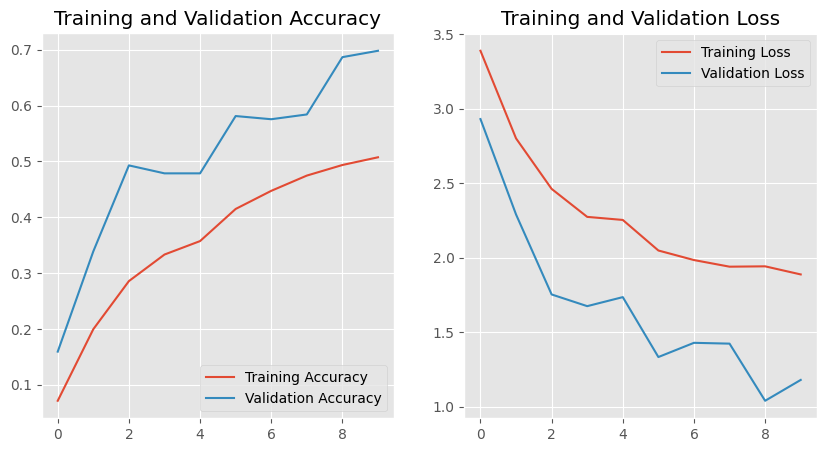

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

检验预测能力

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Loss: {loss:.2f}")
print(f"Accuracy: {accuracy:.2%}")

2023-10-22 15:44:28.612805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/12 [=>............................] - ETA: 29s - loss: 1.2356 - accuracy: 0.6250

2023-10-22 15:44:30.824133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/12 [==============================] - 4s 100ms/step - loss: 1.2192 - accuracy: 0.6017
Loss: 1.22
Accuracy: 60.17%
